In [1]:
import pandas as pd
import numpy as np
from surprise import Dataset
from surprise import Reader

In [2]:
PATH = "../dataset/"
user_path = "dataset1/user.csv"
movie_path = "dataset1/movie.csv"

In [3]:
user = pd.read_csv(PATH + user_path)

In [4]:
movie = pd.read_csv(PATH + movie_path)

In [5]:
# 电影数据按电影名去重，以index+1作为电影id列
movie_grouped = movie.groupby(["电影名"])
movie_distant = movie_grouped.count().reset_index().reset_index()
movie_distant["id"] = movie_distant["index"] + 1
movies = movie_distant[["电影名","id"]]

In [6]:
movies.head(5)

,电影名,id
0,0.5,1
1,007之你死我活,2
2,007之俄罗斯之恋,3
3,007之八爪女,4
4,007之太空城,5


In [7]:
user_movie = pd.merge(user[["用户ID","评分","评论时间","电影名"]],movies,how="left",on="电影名")

In [8]:
user_movie.head()

,用户ID,评分,评论时间,电影名,id
0,1,2,2018-01-05 15:05:06,心雨花露,9078
1,3,4,2018-01-05 15:05:06,战争的恐怖,10396
2,4,2,2018-01-05 15:05:06,豪勇七蛟龙,19714
3,5,2,2018-01-05 15:05:06,无序之主,11335
4,6,4,2018-01-05 15:05:06,时装店风波,11560


## 分析一下数据

In [9]:
import matplotlib.pyplot as plt 
import seaborn as sns
sns.set(color_codes=True)
np.random.seed(sum(map(ord, "distributions")))

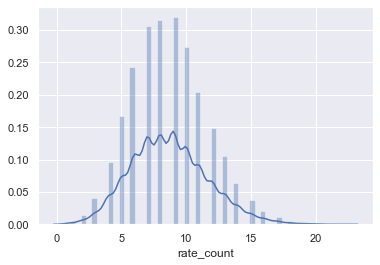

In [10]:
# 统计每部电影的打分数量
movie_rate_count = user_movie[["电影名","评分"]].groupby(["电影名"]).count().reset_index().rename({"评分":"rate_count"})
movie_rate_count.rename(columns={"评分":"rate_count"},inplace=True)
movie_rate_count.sort_values("rate_count",inplace=True)

sns.distplot(movie_rate_count["rate_count"],kde=True)

* 该数据打分记录不完整

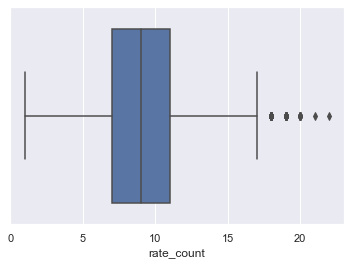

In [11]:
sns.boxplot(movie_rate_count["rate_count"])

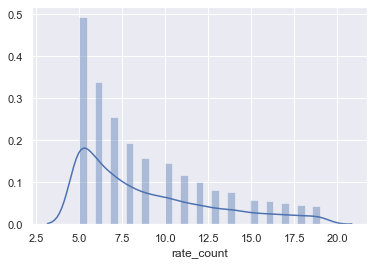

In [12]:
# 用户打分样本数量分布
movie_rate_count = user_movie[["用户ID","评分"]].groupby(["用户ID"]).count().reset_index()
movie_rate_count.rename(columns={"评分":"rate_count"},inplace=True)
movie_rate_count.sort_values("rate_count",inplace=True)

sns.distplot(movie_rate_count.loc[movie_rate_count["rate_count"] < 20,"rate_count"],kde=True)

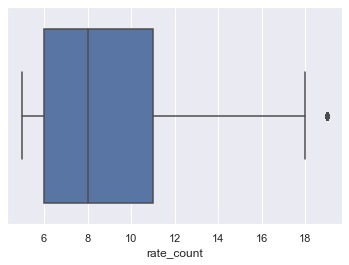

In [13]:
sns.boxplot(movie_rate_count.loc[movie_rate_count["rate_count"] < 20,"rate_count"])

In [14]:
movie_rate_count.loc[movie_rate_count["rate_count"] > 20,:]

,用户ID,rate_count
4561,8946,21
3437,6726,21
3905,7852,21
3829,7629,21
607,922,21
...,...,...
398,655,209
1308,2248,219
287,514,220
2088,3935,222


In [15]:
movie_rate_count.rename(columns={"评分":"rate_count"},inplace=True)

In [16]:
movie_rate_count.sort_values("rate_count",inplace=True)

In [17]:
user_movie_std = user_movie[["用户ID","id","评分"]]

In [18]:
#  基于user.csv,movie.csv处理得到的surprise打分数据
reader = Reader(rating_scale=(1,10))
data1 = Dataset.load_from_df(user_movie_std,reader=reader)

In [19]:
# 使用评论数据集
comment = pd.read_csv("../dataset/DMSC.csv")
# 清除用户名为[已注销]或已注销的数据
comment = comment.loc[comment.Username != "[已注销]",["Username","Movie_Name_CN","Star"]]
# 基于DMSC.csv处理得到的surprise打分数据
reader = Reader(rating_scale=(1,5))
data2 = Dataset.load_from_df(comment,reader=reader)

## 使用协同过滤建模

### user.csv,movie.csv处理得到的surprise打分数据：data1

In [49]:
# 考虑基线的协同过滤
from surprise import KNNBaseline
from surprise.model_selection import cross_validate
# 参数设置：使用皮尔逊相似度
sim_options = {'name': 'pearson'}
algo_KNNBaseline = KNNBaseline(k=40,sim_options=sim_options)

pref = cross_validate(algo=algo_KNNBaseline,data=data1,cv=5,measures=["RMSE","MAE"])

Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson similarity matrix...
Done computing similarity matrix.


In [53]:
# 查看训练效果
print("5折交叉验证平均rmse：")
print(sum(pref["test_rmse"])/5)
print("5折交叉验证平均mae：")
print(sum(pref["test_mae"])/5)

5折交叉验证平均rmse：
2.3827889884601303
5折交叉验证平均mae：
1.986311888521282


### DMSC.csv处理得到的surprise打分数据:data2

In [54]:
# 考虑基线的协同过滤
from surprise import KNNBaseline
from surprise.model_selection import cross_validate
# 参数设置：使用皮尔逊相似度
sim_options = {'name': 'pearson'}
algo_KNNBaseline = KNNBaseline(k=40,sim_options=sim_options)

pref = cross_validate(algo=algo_KNNBaseline,data=data2,cv=5,measures=["RMSE","MAE"])

Estimating biases using als...
Computing the pearson similarity matrix...


MemoryError: Unable to allocate 1.54 TiB for an array with shape (649841, 649841) and data type int32

* 内存不够用

## 使用SVD模型建模

### user.csv,movie.csv处理得到的surprise打分数据：data1

In [20]:
from surprise import SVD
from surprise.model_selection import GridSearchCV

In [67]:
# 损失;rmse
param_grid = {'n_epochs': [25, 26, 27, 28, 29, 30], 'lr_all': [0.005, 0.001]}
grid_search_rmse = GridSearchCV(SVD, param_grid=param_grid, measures=["rmse"], cv=5)
grid_search_rmse.fit(data1)

In [68]:
# 输出最好的参数
grid_search_rmse.best_params

{'rmse': {'n_epochs': 25, 'lr_all': 0.005}}

In [73]:
# 最好的rmse误差结果
result = grid_search_rmse.cv_results
result["mean_test_rmse"][0]

2.3053590863928393

In [74]:
# 损失：mae
param_grid = {'n_epochs': [31,32,33,34,35,36,37,38,39], 'lr_all': [0.002, 0.005]}
grid_search_mae = GridSearchCV(SVD, param_grid=param_grid, measures=["mae"], cv=5)
grid_search_mae.fit(data1)

In [75]:
# 输出最好的参数
grid_search_mae.best_params

{'mae': {'n_epochs': 37, 'lr_all': 0.005}}

In [76]:
# 最好的mae误差结果
grid_search_mae.cv_results["mean_test_mae"][-3]

1.8809955272019352

### DMSC.csv处理得到的surprise打分数据:data2

In [21]:
# 损失;rmse
param_grid = {'n_epochs': [25], 'lr_all': [0.005]}
grid_search_rmse = GridSearchCV(SVD, param_grid=param_grid, measures=["rmse"], cv=5)
grid_search_rmse.fit(data2)

In [24]:
# 平均rmse
grid_search_rmse.cv_results["mean_test_rmse"]

array([1.09407528])

In [22]:
# 损失：mae
param_grid = {'n_epochs': [37], 'lr_all': [0.005]}
grid_search_mae = GridSearchCV(SVD, param_grid=param_grid, measures=["mae"], cv=5)
grid_search_mae.fit(data2)

In [25]:
# 平均mae
grid_search_mae.cv_results["mean_test_mae"]

array([0.86024538])